In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import json
from scipy.ndimage import rotate
import copy

# Gold by reason 

In [3]:
reasons = ['0', '6', '2', '5', '13', '1', '12', '15', '11', '14']

In [4]:
columns_gold = ['reason_0', 'reason_6', 'reason_2',
                'reason_5', 'reason_13','reason_1',
                'reason_12', 'reason_15', 'reason_11',
                'reason_14']

def get_gold_reason(lines, placeholder=-1, n=None):
    
    if n == None:
        n = len(lines)
        
    data = []
    for elem in lines:
        gold_reason = elem['gold_by_reason']
        data.append(gold_reason)
        
    return data

In [5]:
train_paths = ['sberbank_data/final/academy2019_final_train.jsonlines']

In [6]:
buff = []
ids = []

data_reasons = [] 

total = 40403
batch_size = 5000
for path in train_paths:
    with open(path) as inp:
        for i, line in tqdm(enumerate(inp), total=total):
            record = json.loads(line)
            buff.append(record)
            ids.append(record['id'])

            if (i + 1) % batch_size == 0:
                # extract features
                data_reasons += get_gold_reason(buff)

                # free buff
                buff = []

        # process last batch
        data_reasons += get_gold_reason(buff)

        # free buff
        buff = []

100%|██████████| 40403/40403 [01:10<00:00, 574.01it/s]


## Reasons DF

In [6]:
reasons_df = pd.DataFrame(data_reasons).fillna(-100000)

# Player pos 

In [7]:
def scale_data(x):
    """
    Приводит данные к [0, 1]
    """
    max_x = x.max()
    min_x = x.min()
    
    x = (x - min_x) / (max_x - min_x)
    return x

In [24]:
# читаем данные

In [8]:
poisitions_x = []
poisitions_y = []

skilled = []
record_ids = []

max_pos_x = 0
max_pos_y = 0
team_name = []
total = 40403
with open('sberbank_data/final/academy2019_final_train.jsonlines') as fin:
    for i, line in tqdm(enumerate(fin), total=total):
        record = json.loads(line)
        
        # read one line
        skilled.append(record['skilled'])
        record_ids.append(record['id'])
        team_name.append(record['player_team'])
        
        # обработка записи
        pos_x = record['actions']['pos_x']
        pos_y = record['actions']['pos_y']
        
        poisitions_x.append(pos_x)
        poisitions_y.append(pos_y)
        
        max_pos_x = max(max(pos_x), max_pos_x)
        max_pos_y = max(max(pos_y), max_pos_y)
        
        i += 1

print("max_pos_x: %d  |  max_pos_y: %d" % (max_pos_x, max_pos_y))

100%|██████████| 40403/40403 [00:56<00:00, 708.99it/s]

max_pos_x: 2147483647  |  max_pos_y: 2147483647


In [9]:
### Обработаем позиции 

# тут будут лежать хитмапы
heatmaps_pos = np.zeros((40403, 64, 64))

for i, (x, y) in tqdm(enumerate(zip(poisitions_x, poisitions_y)), total=40403):
    hist = np.zeros((64, 64)) 
    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)
    
    
    x = (np.array(x) - min_x) / (max_x - min_x)
    y = (np.array(y) - min_y) / (max_y - min_y)
    
    hist[np.ceil(x * 64).astype(int) - 1, np.ceil(y * 64).astype(int) - 1] += 1
    heatmaps_pos[i] = hist

100%|██████████| 40403/40403 [00:15<00:00, 2556.86it/s]


In [10]:
# готовим для нейронки на keras
X_pos = np.expand_dims(heatmaps_pos, -1)

# нормируем все значения на [0, 1]
X_pos = scale_data(X_pos)

## Rotate Dire map 

In [11]:
def rotate_pos(X_pos, team_names):
    """
    Чтобы для всех игроков своя база была внизу, а 
    база врага наверху - перевернем карту для dire
    """
    new_pos = copy.deepcopy(X_pos)
    
    for ind in range(len(X_pos)):
        if team_name[ind] == 'dire':
            new_pos[ind] = rotate(new_pos[ind], 180)
    
    return new_pos

## Before rotate 

In [12]:
team_name[16]

'dire'

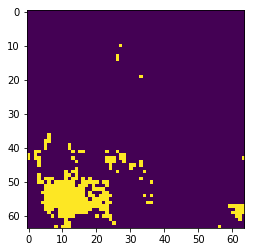

In [13]:
plt.imshow(np.squeeze(X_pos[16]))

## After rotate 

In [14]:
new_position = rotate_pos(X_pos, team_name)

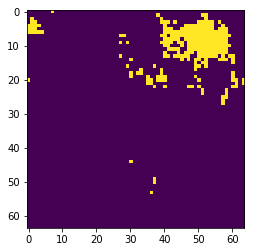

In [15]:
plt.imshow(np.squeeze(new_position[16]))

# Player cursor pos

In [16]:
cursors_x = []
cursors_y = []

skilled = []
record_ids = []

total = 40403
with open('sberbank_data/final/academy2019_final_train.jsonlines') as fin:
    for i, line in tqdm(enumerate(fin), total=total):
        record = json.loads(line)
        
        # read one line
        skilled.append(record['skilled'])
        record_ids.append(record['id'])
        
        
        # обработка записи
        cursors_x.append(record['actions']['cursor_y'])
        cursors_y.append(record['actions']['cursor_x'])
            
        
        i += 1

100%|██████████| 40403/40403 [01:01<00:00, 656.88it/s]


In [17]:
heatmaps = np.zeros((40403, 64, 64))

In [18]:
for i, (x, y) in tqdm(enumerate(zip(cursors_x, cursors_y)), total=40403):
    hist = np.zeros((511, 511)) 
    hist[np.array(x) - 1, np.array(y) - 1] += 1
    res = cv2.resize(hist, dsize=(64, 64),interpolation=cv2.INTER_AREA) 
    
    heatmaps[i] = res

100%|██████████| 40403/40403 [00:25<00:00, 1594.88it/s]


In [19]:
# готовим для нейронки на keras
X_cur = np.expand_dims(heatmaps, -1)

# нормируем все значения на [0, 1]
X_cur = scale_data(X_cur)

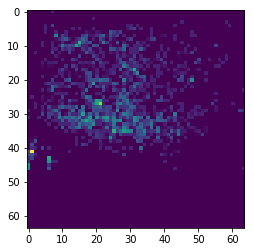

In [20]:
plt.imshow(np.squeeze(X_cur[30]))

# Encoder-decoder


In [21]:
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Input, Dense, Reshape
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.datasets import mnist
from keras import Model

Using TensorFlow backend.


## Позиция игрока на карте - вектор из 128 признаков 

In [30]:
input_ = Input((64, 64, 1)) 

x = Conv2D(filters=4, kernel_size=2, strides=2, activation='relu',padding='same')(input_) 
x = Conv2D(filters=6, kernel_size=2, strides=2, activation='relu',padding='same')(x)
x = Conv2D(filters=8,kernel_size=2, strides=2, activation='relu',padding='same')(x) 
flat = Flatten()(x)
latent = Dense(128,activation='relu')(flat)


reshape = Reshape((-1,8,8)) 
dense = Dense(512,activation='relu')
conv_2t_1 = Conv2DTranspose(filters=8, kernel_size=2, strides=2, activation='relu',padding='same') 
conv_2t_2 = Conv2DTranspose(filters=6, kernel_size=2, strides=2, activation='relu',padding='same') 
conv_2t_3 = Conv2DTranspose(filters=1, kernel_size=2, strides=2, activation='relu',padding='same') 
 

x = dense(latent)
x = reshape(x)
x = conv_2t_1(x)
x = conv_2t_2(x)
decoded = conv_2t_3(x) 

autoencoder = Model(input_, decoded)
encoder = Model(input_, latent)

decoder_input = Input((128,))
x_ = dense(decoder_input)
x_ = reshape(x_)
x_ = conv_2t_1(x_)
x_ = conv_2t_2(x_)
decoded_ = conv_2t_3(x_) 
decoder = Model(decoder_input, decoded_)

In [31]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [317]:
# autoencoder.summary()

In [32]:
autoencoder.fit(x = new_position, y =new_position, batch_size=128, epochs=27)

Epoch 1/27
40403/40403 [==============================] - 3s 72us/step - loss: 0.4123
Epoch 2/27
40403/40403 [==============================] - 2s 61us/step - loss: 0.2858
Epoch 3/27
40403/40403 [==============================] - 2s 62us/step - loss: 0.1859
Epoch 4/27
40403/40403 [==============================] - 2s 61us/step - loss: 0.1786
Epoch 5/27
40403/40403 [==============================] - 2s 61us/step - loss: 0.1700
Epoch 6/27
40403/40403 [==============================] - 2s 61us/step - loss: 0.1663
Epoch 7/27
40403/40403 [==============================] - 2s 61us/step - loss: 0.1621
Epoch 8/27
40403/40403 [==============================] - 2s 62us/step - loss: 0.1614
Epoch 9/27
40403/40403 [==============================] - 2s 62us/step - loss: 0.1617
Epoch 10/27
40403/40403 [==============================] - 2s 62us/step - loss: 0.1575
Epoch 11/27
40403/40403 [==============================] - 2s 62us/step - loss: 0.1666
Epoch 12/27
40403/40403 [===========================

In [33]:
pred = encoder.predict(np.expand_dims(new_position[202],axis=0))

In [34]:
pred.shape

(1, 128)

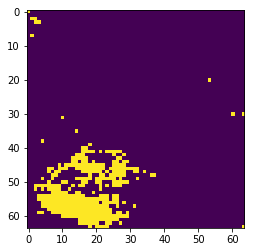

In [35]:
plt.imshow(np.squeeze(new_position[202])) # Реальное

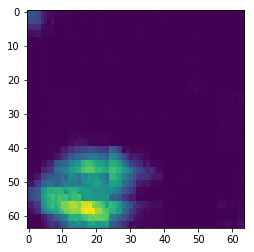

In [36]:
plt.imshow(np.squeeze(decoder.predict(pred)[0])) # Восстановленное из вектора 128 признаков

## Курсор мыши 

In [37]:
input_ = Input((64, 64, 1)) 

x = Conv2D(filters=4, kernel_size=2, strides=2, activation='relu',padding='same')(input_) 
x = Conv2D(filters=6, kernel_size=2, strides=2, activation='relu',padding='same')(x)
x = Conv2D(filters=8,kernel_size=2, strides=2, activation='relu',padding='same')(x) 
flat = Flatten()(x)
latent = Dense(128,activation='relu')(flat)


reshape = Reshape((-1,8,8)) 
dense = Dense(512,activation='relu')
conv_2t_1 = Conv2DTranspose(filters=8, kernel_size=2, strides=2, activation='relu',padding='same') 
conv_2t_2 = Conv2DTranspose(filters=6, kernel_size=2, strides=2, activation='relu',padding='same') 
conv_2t_3 = Conv2DTranspose(filters=1, kernel_size=2, strides=2, activation='relu',padding='same') 
 

x = dense(latent)
x = reshape(x)
x = conv_2t_1(x)
x = conv_2t_2(x)
decoded = conv_2t_3(x) 

autoencoder_cur = Model(input_, decoded)
encoder_cur = Model(input_, latent)

decoder_input = Input((128,))
x_ = dense(decoder_input)
x_ = reshape(x_)
x_ = conv_2t_1(x_)
x_ = conv_2t_2(x_)
decoded_ = conv_2t_3(x_) 
decoder_cur = Model(decoder_input, decoded_)

In [38]:
autoencoder_cur.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 4)         20        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 6)         102       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 8)           200       
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
__________

In [39]:
autoencoder_cur.compile(optimizer='adam', loss='binary_crossentropy')

In [40]:
autoencoder_cur.fit(x = X_cur, y = X_cur, batch_size=256, epochs=27)

Epoch 1/27
40403/40403 [==============================] - 3s 70us/step - loss: 0.0602
Epoch 2/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0526
Epoch 3/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0510
Epoch 4/27
40403/40403 [==============================] - 2s 59us/step - loss: 0.0498
Epoch 5/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0495
Epoch 6/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0493
Epoch 7/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0492
Epoch 8/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0491
Epoch 9/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0491
Epoch 10/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0490
Epoch 11/27
40403/40403 [==============================] - 2s 58us/step - loss: 0.0490
Epoch 12/27
40403/40403 [===========================

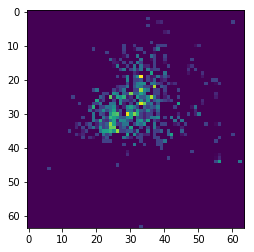

In [41]:
plt.imshow(np.squeeze(X_cur[10]))

In [42]:
test_dims = np.expand_dims(X_cur[10],axis=0)

In [43]:
test_dims.shape

(1, 64, 64, 1)

In [44]:
pred_cur = encoder_cur.predict(test_dims)

In [45]:
decoded_cur = decoder_cur.predict(pred_cur)

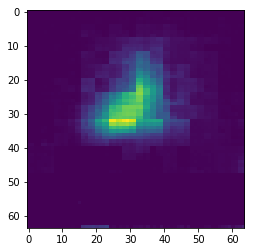

In [46]:
plt.imshow(np.squeeze(decoded_cur))

# Add new features to DF 

In [67]:
df_train = pd.read_csv('sberbank_data/data_2019/train_extracted_final_v2.csv').drop('id',axis=1)

In [64]:
reasons_df.shape, df_train.shape

((40403, 10), (40403, 808))

In [68]:
df_train = pd.concat([df_train,reasons_df],axis=1)

In [71]:
cursor_data = encoder_cur.predict(X_cur)

In [80]:
pos_data = encoder.predict(new_position)

In [84]:
pos_columns = ['pos_'+str(i) for i in range(1,129)]
cur_columns = ['cur'+str(i) for i in range(1,129)]

In [99]:
extra_data = np.concatenate([pos_data, cursor_data],axis=1)

In [101]:
extra_data_df = pd.DataFrame(data=extra_data, columns = pos_columns+cur_columns)

In [104]:
full_train = pd.concat([df_train, extra_data_df], axis=1)